# Brain Tumor Detection Using a Convolutional Neural Network
#### About the Brain MRI Images dataset:
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it here.

## Import Necessary Modules

In [1]:
# !pip install tensorflow

In [2]:
!pip install opencv-python
!pip install imutils

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing
In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here Finding extreme points in contours with OpenCV.

In [4]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

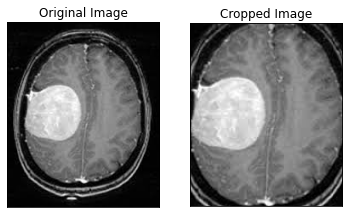

In [5]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:
The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following:

Read the image.
Crop the part of the image representing only the brain.
Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
Apply normalization because we want pixel values to be scaled to the range 0-1.
Append the image to X and its label to y.
After that, Shuffle X and y, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).
Finally, Return X and y.

In [6]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.\
Note: the augmented data directory contains not only the new generated images but also the original images.

In [7]:
augmented_path = 'augmented data1/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2064
X shape is: (2064, 240, 240, 3)
y shape is: (2064, 1)


As we see, we have 2064 images. Each images has a shape of (240, 240, 3)=(image_width, image_height, number_of_channels)

### Plot sample images:

In [8]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

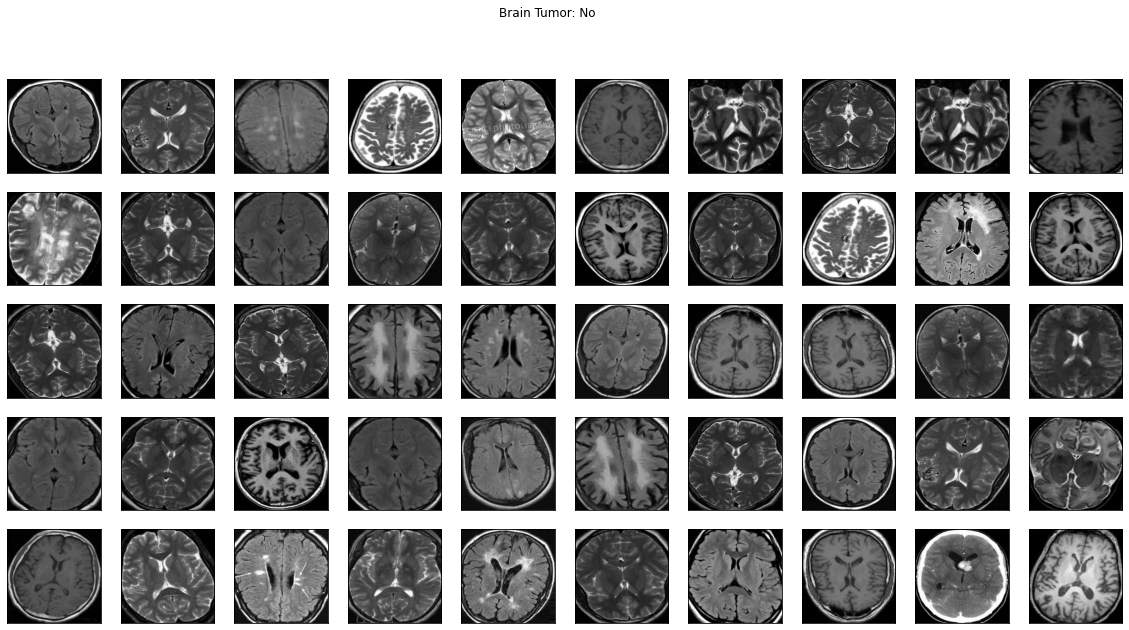

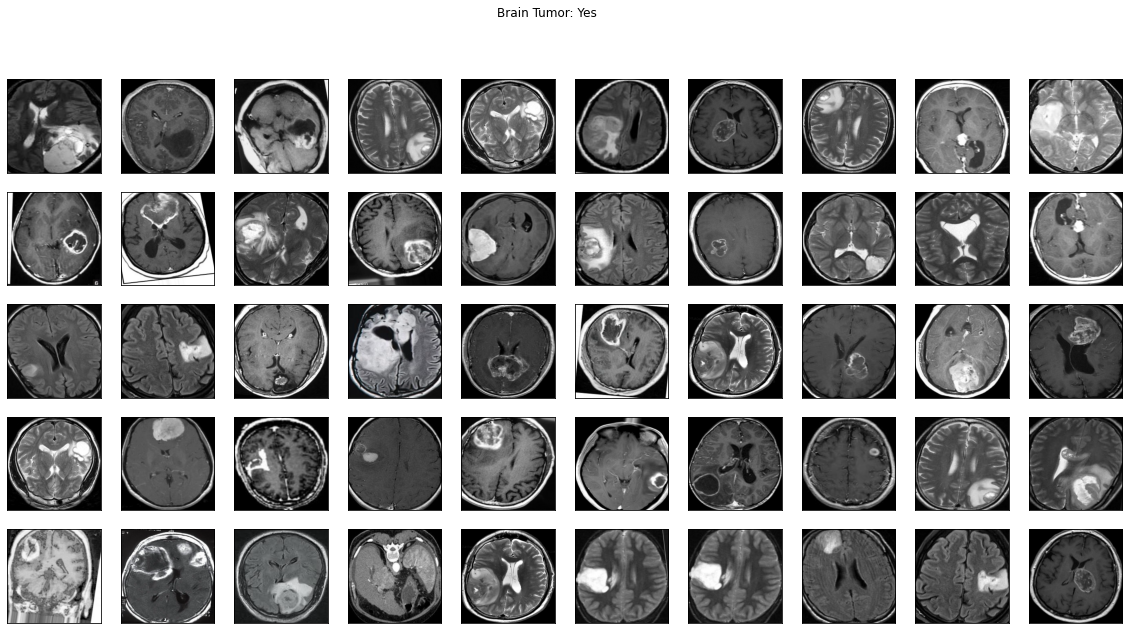

In [9]:
plot_sample_images(X, y)

## Split the data:
Split X and y into training, validation (development) and validation sets.

In [10]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

<strong>Let's use the following way to split:</strong>

1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [12]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1444
number of development examples = 310
number of test examples = 310
X_train shape: (1444, 240, 240, 3)
Y_train shape: (1444, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


<strong>Some helper functions:</strong>

In [13]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [14]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

## Build the model
Let's build a convolutional neural network model:

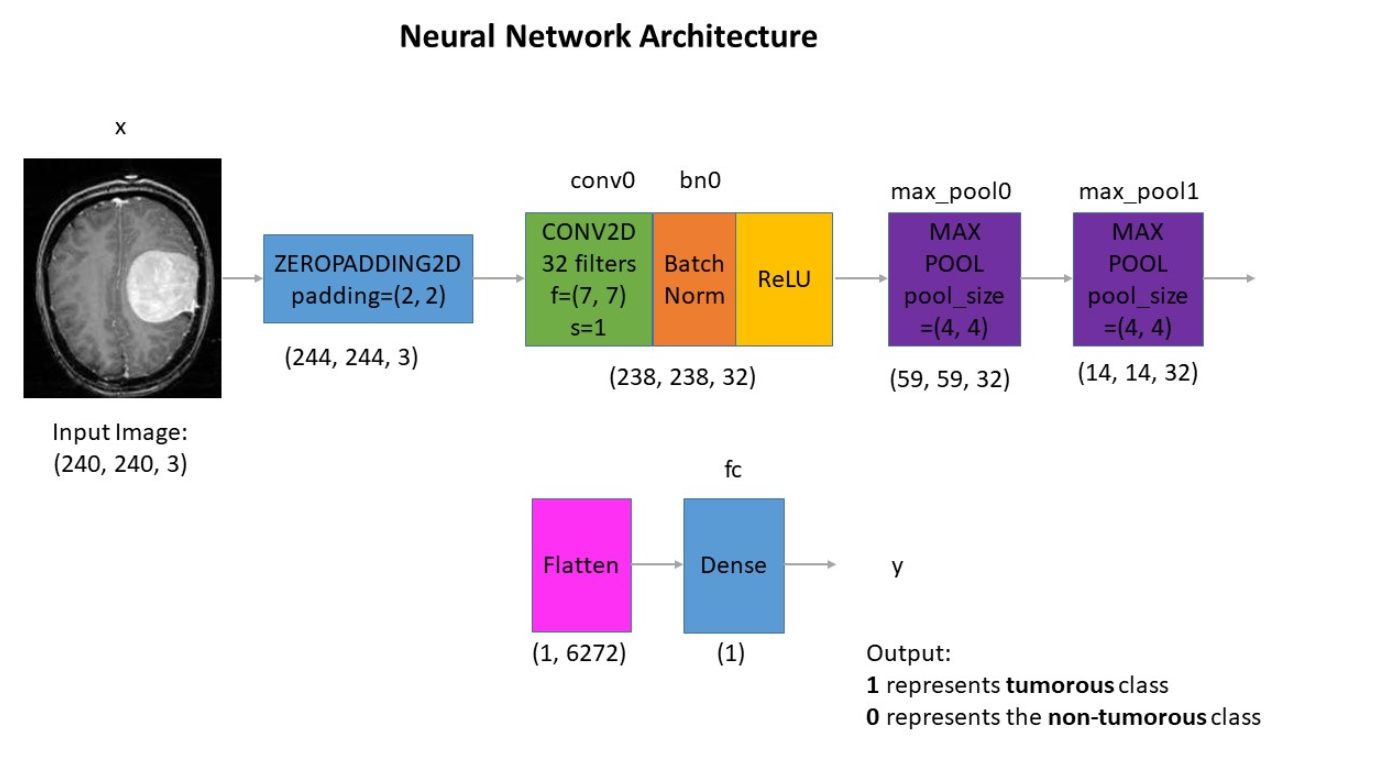

In [15]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

<strong>Define the image shapes:</strong>

In [16]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [17]:
model = build_model(IMG_SHAPE)

In [18]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

### Compile the Model:

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [21]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

### Train the model

In [22]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - 98s 2s/step - loss: 0.8443 - accuracy: 0.6060 - val_loss: 0.6733 - val_accuracy: 0.5903
Epoch 2/10
46/46 [==============================] - 84s 2s/step - loss: 0.4819 - accuracy: 0.7722 - val_loss: 0.6200 - val_accuracy: 0.7065
Epoch 3/10
46/46 [==============================] - 78s 2s/step - loss: 0.4182 - accuracy: 0.8193 - val_loss: 0.5786 - val_accuracy: 0.6774
Epoch 4/10
46/46 [==============================] - 78s 2s/step - loss: 0.3575 - accuracy: 0.8511 - val_loss: 0.5183 - val_accuracy: 0.8032
Epoch 5/10
46/46 [==============================] - 79s 2s/step - loss: 0.3441 - accuracy: 0.8532 - val_loss: 0.5925 - val_accuracy: 0.6290
Epoch 6/10
46/46 [==============================] - 76s 2s/step - loss: 0.3498 - accuracy: 0.8442 - val_loss: 0.4162 - val_accuracy: 0.8226
Epoch 7/10
46/46 [==============================] - 76s 2s/step - loss: 0.3102 - accuracy: 0.8760 - val_loss: 0.3781 - val_accuracy: 0.8516
Epoch 8/10
46/46 [==

<strong>Let's train for a few more epochs:</strong>

In [23]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 89s 2s/step - loss: 0.2330 - accuracy: 0.9134 - val_loss: 0.3033 - val_accuracy: 0.8903
Epoch 2/3
46/46 [==============================] - 81s 2s/step - loss: 0.1835 - accuracy: 0.9425 - val_loss: 0.3930 - val_accuracy: 0.8290
Epoch 3/3
46/46 [==============================] - 78s 2s/step - loss: 0.1748 - accuracy: 0.9391 - val_loss: 0.3245 - val_accuracy: 0.8806
Elapsed time: 0:4:11.0


In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 85s 2s/step - loss: 0.1728 - accuracy: 0.9398 - val_loss: 0.2814 - val_accuracy: 0.9000
Epoch 2/3
46/46 [==============================] - 82s 2s/step - loss: 0.1887 - accuracy: 0.9259 - val_loss: 0.3124 - val_accuracy: 0.8742
Epoch 3/3
46/46 [==============================] - 80s 2s/step - loss: 0.1506 - accuracy: 0.9508 - val_loss: 0.4290 - val_accuracy: 0.8258
Elapsed time: 0:4:12.4


In [25]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 84s 2s/step - loss: 0.1562 - accuracy: 0.9467 - val_loss: 0.5626 - val_accuracy: 0.7613
Epoch 2/3
46/46 [==============================] - 80s 2s/step - loss: 0.1614 - accuracy: 0.9411 - val_loss: 0.3010 - val_accuracy: 0.8742
Epoch 3/3
46/46 [==============================] - 79s 2s/step - loss: 0.1428 - accuracy: 0.9474 - val_loss: 0.2797 - val_accuracy: 0.8935
Elapsed time: 0:4:7.0


In [26]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
46/46 [==============================] - 85s 2s/step - loss: 0.1361 - accuracy: 0.9515 - val_loss: 0.2678 - val_accuracy: 0.8968
Epoch 2/5
46/46 [==============================] - 83s 2s/step - loss: 0.1065 - accuracy: 0.9695 - val_loss: 0.2631 - val_accuracy: 0.9097
Epoch 3/5
46/46 [==============================] - 78s 2s/step - loss: 0.1194 - accuracy: 0.9654 - val_loss: 0.4825 - val_accuracy: 0.8000
Epoch 4/5
46/46 [==============================] - 82s 2s/step - loss: 0.0892 - accuracy: 0.9785 - val_loss: 0.2851 - val_accuracy: 0.9000
Epoch 5/5
46/46 [==============================] - 79s 2s/step - loss: 0.0902 - accuracy: 0.9765 - val_loss: 0.5961 - val_accuracy: 0.7548
Elapsed time: 0:6:52.1


In [27]:
history = model.history.history

In [28]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


## Plot Loss & Accuracy

In [29]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

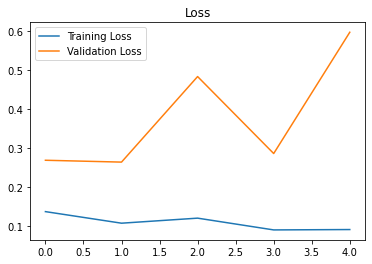

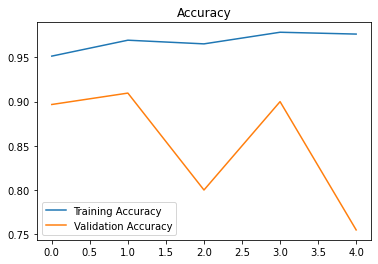

In [30]:
plot_metrics(history) 

## Results
Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 23rd iteration with validation accuracy of 91%

### Load the best model

In [31]:
#best_model = load_model(filepath='cnn-parameters-improvement-23-0.91.model')
#best_model = load_model(filepath='Brain_Tumor_Detection/models')
best_model = load_model(filepath='models/cnn-parameters-improvement-23-0.91.model')

In [41]:
best_model.metrics_names

['loss', 'accuracy']

Evaluate the best model on the testing data:

In [32]:
loss, accuracy = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 4s 350ms/step - loss: 0.2682 - accuracy: 0.8935


### Accuracy of the best model on the testing data:

In [33]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.2682258188724518
Test Accuracy = 0.8935483694076538


### F1 score for the best model on the testing data:

In [34]:
y_test_prob = best_model.predict(X_test)

In [35]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.902654867256637


Let's also find the f1 score on the validation data:

In [36]:
y_val_prob = best_model.predict(X_val)

In [37]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.878892733564014


### Results Interpretation
Let's remember the percentage of positive and negative examples:

In [38]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 

In [39]:
# the whole data
data_percentage(y)

Number of examples: 2064
Percentage of positive examples: 52.51937984496124%, number of pos examples: 1084
Percentage of negative examples: 47.48062015503876%, number of neg examples: 980


In [40]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1444
Percentage of positive examples: 52.908587257617725%, number of pos examples: 764
Percentage of negative examples: 47.091412742382275%, number of neg examples: 680
Validation Data:
Number of examples: 310
Percentage of positive examples: 47.096774193548384%, number of pos examples: 146
Percentage of negative examples: 52.903225806451616%, number of neg examples: 164
Testing Data:
Number of examples: 310
Percentage of positive examples: 56.12903225806452%, number of pos examples: 174
Percentage of negative examples: 43.87096774193548%, number of neg examples: 136


## Conclusion:
#### Now, the model detects brain tumor with:

88.7% accuracy on the test set.
0.88 f1 score on the test set.
These resutls are very good considering that the data is balanced.

#### Performance Table:

    Validation set	Test set
    Accuracy	91%	89%
    F1 score	0.91	0.88
    
Hooray!